In [1]:
# Using the daily K-line data of Maotai's stock, use the opening price of 60 consecutive days to predict the opening price of the 61st day
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dropout,Dense,LSTM

import pandas as pd

import numpy as np

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error,mean_absolute_error

import math
import os

In [2]:
# load data
maotai=pd.read_csv('maotaigupiao.csv')
# Top 2126 rows of data as training set, We only use the data of the opening price that is the open column 
training_set=maotai.iloc[:2426-300,2:3].values
# The last 300 rows of data are used as test set
test_set=maotai.iloc[2426-300:,2:3].values

In [4]:
maotai.head()

,Unnamed: 0,date,open,close,high,low,volume,code
0,74,2010-04-26,88.702,87.381,89.072,87.362,107036.13,600519
1,75,2010-04-27,87.355,84.841,87.355,84.681,58234.48,600519
2,76,2010-04-28,84.235,84.318,85.128,83.597,26287.43,600519
3,77,2010-04-29,84.592,85.671,86.315,84.592,34501.20,600519
4,78,2010-04-30,83.871,82.340,83.871,81.523,85566.70,600519


In [5]:
maotai.describe()

,Unnamed: 0,open,close,high,low,volume,code
count,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.0
mean,1286.500000,353.664043,354.256089,358.460129,349.579923,38385.635730,600519.0
std,700.470199,315.048690,315.628478,318.981678,311.655009,23913.149073,0.0
min,74.000000,80.406000,80.578000,81.363000,80.087000,7439.110000,600519.0
25%,680.250000,133.490250,133.745250,135.154500,131.785000,23352.000000,600519.0
50%,1286.500000,185.439500,186.128500,189.794000,182.796000,32371.000000,600519.0
75%,1892.750000,553.138500,554.542500,562.807750,549.070000,46266.250000,600519.0
max,2499.000000,1250.000000,1252.260000,1265.680000,1247.770000,289140.000000,600519.0


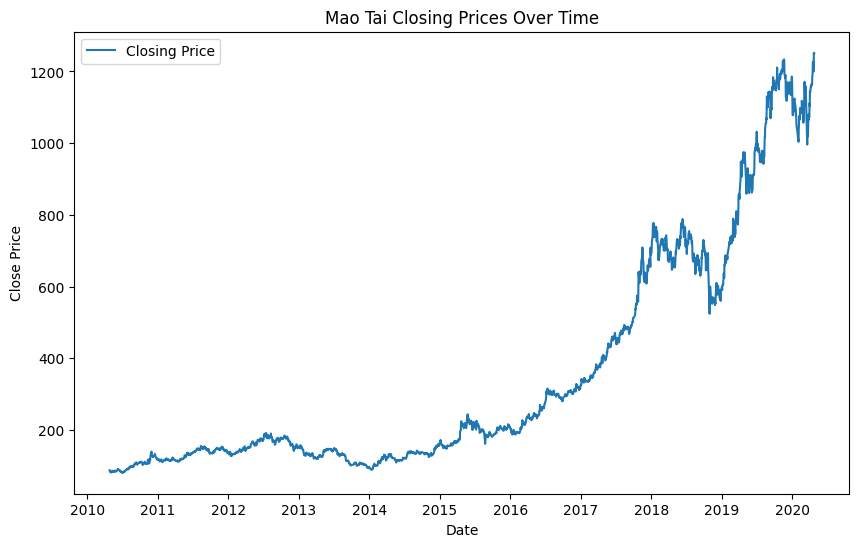

In [8]:
# Plotting the closing prices over time
maotai['date'] = pd.to_datetime(maotai['date'])
plt.figure(figsize=(10, 6))
plt.plot(maotai['date'], maotai['close'], label='Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Mao Tai Closing Prices Over Time')
plt.legend()
plt.show()

In [52]:
# MinMaxScaler: Normalization to 0-1
sc=MinMaxScaler(feature_range=(0,1))
training_set_scaler=sc.fit_transform(training_set) 
test_set_scaler=sc.transform(test_set)

In [53]:
x_train,y_train,x_test,y_test=[],[],[],[]  # Create empty list
for i in range(60,len(training_set_scaler)):
    x_train.append(training_set_scaler[i-60:i,0])
    y_train.append(training_set_scaler[i,0])
    pass

# Convert the list to array format for train set

np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
np.random.seed(7)

x_train,y_train=np.array(x_train),np.array(y_train)

x_train=np.reshape(x_train,(x_train.shape[0],60,1))

In [54]:
# convert the list to array format for test set
for i in range(60,len(test_set_scaler)):
    x_test.append(test_set_scaler[i-60:i,0])
    y_test.append(test_set_scaler[i,0])
    pass

x_test,y_test=np.array(x_test),np.array(y_test)

x_test=np.reshape(x_test,(x_test.shape[0],60,1))

In [83]:
# Create LSTM model
model=tf.keras.Sequential([
    LSTM(100,return_sequences=True),
    Dropout(0.2),
    LSTM(120, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])

In [84]:
# Compile model
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),# Optimizer
              loss='mean_squared_error') # Loss function

In [85]:
# Train model
history = model.fit(x_train, y_train, batch_size=64, epochs=60, validation_split=0.1)
model.summary() # Print model structure

Epoch 1/60
30/30 [==============================] - 8s 121ms/step - loss: 0.0541 - val_loss: 0.0100
Epoch 2/60
30/30 [==============================] - 3s 91ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 3/60
30/30 [==============================] - 3s 84ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 4/60
30/30 [==============================] - 3s 87ms/step - loss: 0.0023 - val_loss: 9.9555e-04
Epoch 5/60
30/30 [==============================] - 3s 88ms/step - loss: 0.0021 - val_loss: 9.7228e-04
Epoch 6/60
30/30 [==============================] - 3s 86ms/step - loss: 0.0021 - val_loss: 9.3521e-04
Epoch 7/60
30/30 [==============================] - 3s 87ms/step - loss: 0.0017 - val_loss: 9.1518e-04
Epoch 8/60
30/30 [==============================] - 3s 88ms/step - loss: 0.0017 - val_loss: 8.9813e-04
Epoch 9/60
30/30 [==============================] - 3s 87ms/step - loss: 0.0016 - val_loss: 8.6867e-04
Epoch 10/60
30/30 [==============================] - 3s 93ms/step - loss: 0.0020 - v

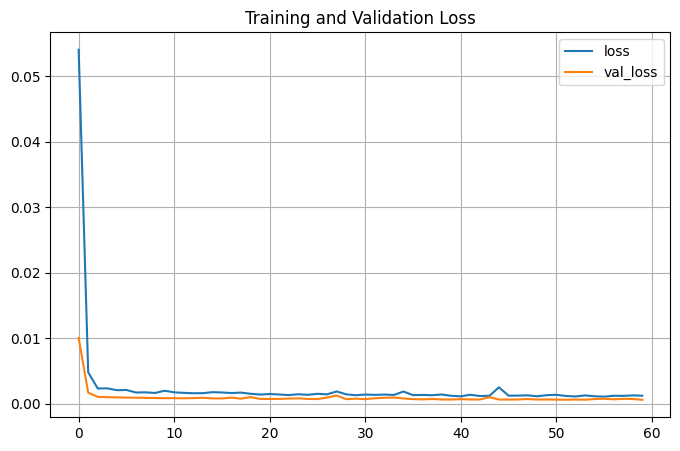

In [86]:
# Draw the loss curve
data={}
data['loss']=history.history['loss']

data['val_loss']=history.history['val_loss']
pd.DataFrame(data).plot(figsize=(8,5))
plt.grid(True)
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

8/8 [==============================] - 1s 32ms/step


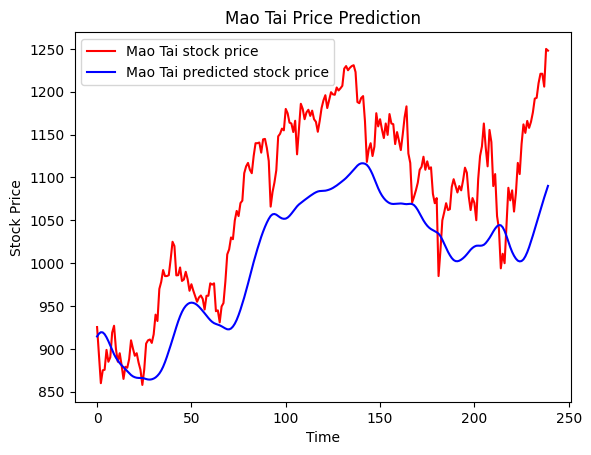

In [87]:
# Predict stock price of test set 
predicted_stock_price=model.predict(x_test)
# Inverse normalization to get the real stock price 
predicted_stock_price=sc.inverse_transform(predicted_stock_price)
predicted_stock_price

# Get the real stock price of test set
real_stock_price=sc.inverse_transform(test_set_scaler[60:])
real_stock_price
# Calculate the RMSE value

plt.plot(real_stock_price,color='red',label='Mao Tai stock price') #Truth value is red line

plt.plot(predicted_stock_price,color='blue',label='Mao Tai predicted stock price') #Predicted value is blue line

plt.title('Mao Tai Price Prediction')

plt.xlabel('Time')

plt.ylabel('Stock Price')

plt.legend()
plt.show()

In [88]:
# Calculate the RMSE value
mse=mean_squared_error(predicted_stock_price,real_stock_price)
rmse=math.sqrt(mse)

mae=mean_absolute_error(predicted_stock_price,real_stock_price)

print('MSE :%.6f'%mse)
print('RMSE :%.6f'%rmse)
print('MAE :%.6f'%mae)

MSE :7156.744503
RMSE :84.597544
MAE :73.131908
